## Rishi Solution - LeaderBoard - 4

Problem Description

    The food inspection department conducts regular inspection on food quality for various restaurants in the city. It’s a very well documented procedure and over time some good amount of data has been generated out of these inspections. 

    The inspection department would like to predict where they should focus most in terms of their next inspection schedule, so that they can most optimize their time at hand to catch the worst offenders. Can the past inspection or any data that they have collected predict which facility will pass or fail.

    In this hackathon, MachineHack provides you with a subset of this dataset with information on food quality checks conducted on thousands of facilities that serve food across multiple cities. Your objective as a Data Scientist is to predict whether a facility will pass or fail the inspection based on a number of factors.

Objective

Build a predictive model that is capable of predicting the outcome of an inspection conducted in a facility based on the given set of features

Features : 

    ID: A unique id for each inspection

    Date: The date at which the inspection was done in a particular facility

    LicenseNo: De-identified license number for a particular facility

    FacilityID: De-identified unique facility id  for a facility

    FacilityName: The encoded name of a facility

    Type: The type of the facility being inspected

    Street: The encoded street where the facility is located

    City: The encoded city where the facility is located

    State: The encoded state where the facility is located

    LocationID: An encoded location feature.

    Reason: The primary reason for the inspection

    SectionViolations: Laws violated by the facility

    RiskLevel: The level of risk the facility possesses to the consumers.

    Geo_Loc: De-identified geo location of the facility

    Inspection_Results: The result of the inspection

Target :

The inspection results can have any of the following values :

    0:’FACILITY CHANGED’
    1:’FAIL’
    2:’FURTHER INSPECTION REQUIRED’,
    3:’INSPECTION OVERRULED’
    4:’PASS’
    5:’PASS(CONDITIONAL)’
    6:’SHUT-DOWN’

Data Sets:

        Data_Train.xlsx – 147443 rows × 15 columns
        Data_Test.xlsx – 49148 rows × 14 columns
        Sample_Submission.xlsx – 49148 rows × 7 columns



In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re, os, string, datetime
import seaborn as sns
import warnings
pd.set_option('max_columns',500)
warnings.filterwarnings(action='ignore')

In [59]:
%%time
train = pd.read_excel('Data_Train.xlsx')
test = pd.read_excel('Data_Test.xlsx')
sample = pd.read_excel('Sample_Submission.xlsx')

Wall time: 1min 21s


In [60]:
test['index'] = np.arange(0,49148)

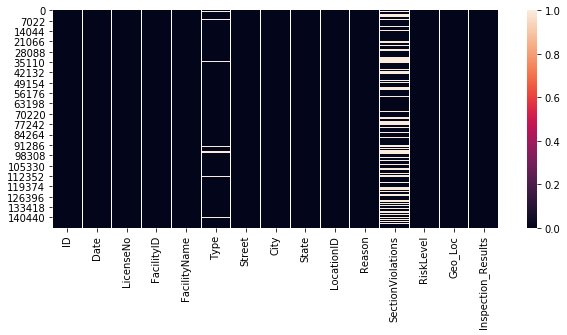

In [61]:
plt.figure(figsize = (10,4))
sns.heatmap(train.isnull())

## Deleting

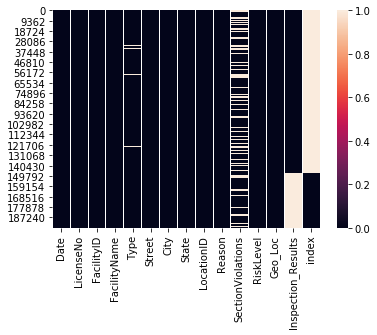

In [62]:
df = train.append(test)
df.reset_index(drop = True, inplace = True)
df.drop(columns = 'ID', inplace = True)
sns.heatmap(df.isnull())

## Date

In [63]:
%%time
def fuc(x):
    try :
        if x == '29-02-2011' :
            x = '01-03-2011'
            x = pd.to_datetime(x)
        elif x == '29-02-2015' :
            x = '01-03-2015'
            x = pd.to_datetime(x)
        else :
            x = pd.to_datetime(x)
    except:
        print(x)
    return(x)
df.Date = df.Date.apply(lambda x: fuc(x))

# d : Timestamp 
d = pd.to_datetime('19-02-2020')

df['day'] = df.Date.dt.day
df['month'] = df.Date.dt.month
df['year'] = df.Date.dt.year
df['dayofweek'] = df.Date.dt.dayofweek
df['dayofyear'] = df.Date.dt.dayofyear
df['weekofyear'] = df.Date.dt.weekofyear

df['day_e'] =   (d-df.Date).dt.days

# Convert into cyclic variable
df['day'] = np.sin(2*np.pi*df.day/max(df.day))
df['month'] = np.sin(2*np.pi*df.month/max(df.month))
df['dayofweek'] = np.sin(2*np.pi*df.dayofweek/max(df.dayofweek))
df['dayofyear'] = np.sin(2*np.pi*df.dayofyear/max(df.dayofyear))
df['weekofyear'] = np.sin(2*np.pi*df.weekofyear/max(df.weekofyear))

Wall time: 46.7 s


In [64]:
df = df.sort_values(by='Date',ascending=True).reset_index(drop=True)

## City

In [65]:
del df['State']
del df['City']

# Reason

In [66]:
df = df.sort_values(by='Date',ascending=True).reset_index(drop=True)

df['Reason_Before'] = df.groupby(['LicenseNo'])['Reason'].shift(1)
df.Reason_Before.fillna('Not-Req', inplace = True)

df = df.sort_values(by='Date',ascending=True).reset_index(drop=True)
df['Reason_After'] = df.groupby(['LicenseNo'])['Reason'].shift(-1)
df.Reason_After.fillna('Not-Req', inplace = True)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df.Reason_Before = le.fit_transform(df.Reason_Before)
df.Reason_After = le.transform(df.Reason_After)
df.Reason = le.transform(df.Reason)

# Risk 

In [67]:
df = df.sort_values(by='Date',ascending=True).reset_index(drop=True)
df['Risk_Before'] = df.groupby(['LicenseNo'])['RiskLevel'].shift(1)
df.Risk_Before.fillna('Not-Req', inplace = True)

df = df.sort_values(by='Date',ascending=True).reset_index(drop=True)
df['Risk_After'] = df.groupby(['LicenseNo'])['RiskLevel'].shift(-1)
df.Risk_After.fillna('Not-Req', inplace = True)

le = LabelEncoder()
df.Risk_After = le.fit_transform(df.Risk_After)
df.Risk_Before = le.transform(df.Risk_Before)
df.RiskLevel = le.transform(df.RiskLevel)

# LocationID

In [68]:
df.LocationID = df.groupby(['Geo_Loc','Street'])['LocationID'].apply(lambda x: x.fillna(x.median()))
df.LocationID.fillna(-999, inplace = True)

## TYPE

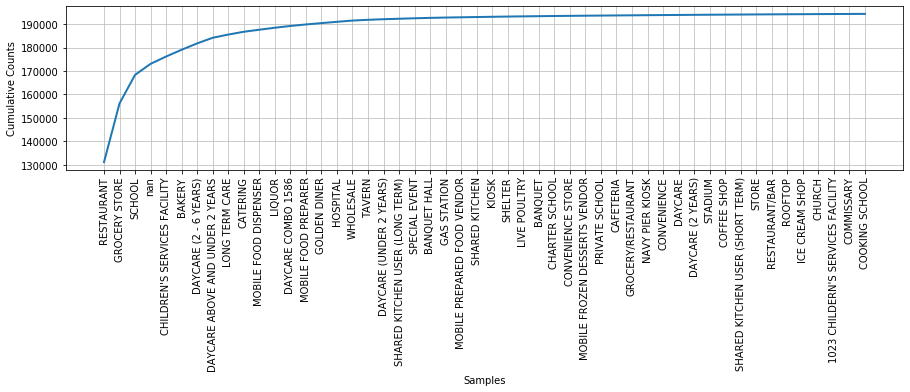

In [69]:
import nltk
frequency = nltk.FreqDist(df.Type.tolist())
plt.figure(figsize = (15,3))
frequency.plot(50,cumulative = True)

In [70]:
Change = dict()
Change = {'DAYCARE COMBO 1586': 'DAYCARE', 'MOBILE FOOD PREPARER':  'MOBILE FOOD DISPENSER', 'WHOLESALE': 'GROCERY STORE',
  'GOLDEN DINER': 'BANQUET HALL' , 'TAVERN': 'LIQUOR', 'DAYCARE ABOVE AND UNDER 2 YEARS' : 'DAYCARE (UNDER 2 YEARS)',
  'SHARED KITCHEN USER (LONG TERM)':'SHARED KITCHEN', 'SPECIAL EVENT':'BANQUET HALL', 
  'MOBILE PREPARED FOOD VENDOR':'MOBILE FOOD DISPENSER', 'KIOSK': 'MOBILE FOOD DISPENSER',
  'BANQUET': 'BANQUET HALL', 'CHARTER SCHOOL': 'SCHOOL', 'CONVENIENCE STORE' : 'GROCERY STORE',
  'MOBILE FROZEN DESSERTS VENDOR' : 'MOBILE FOOD DISPENSER', 'PRIVATE SCHOOL' : 'SCHOOL',
  'CAFETERIA': 'SCHOOL', 'NAVY PIER KIOSK' : 'MOBILE FOOD DISPENSER', 'GROCERY/RESTAURANT' : 'GROCERY STORE',
  'CONVENIENCE': 'GROCERY STORE', 'DAYCARE (2 YEARS)': 'DAYCARE (UNDER 2 YEARS)', 'STADIUM' : 'CATERING',
  'COFFEE SHOP': 'RESTAURANT' , 'SHARED KITCHEN USER (SHORT TERM)': 'SHARED KITCHEN', 
  'STORE' : 'GROCERY STORE', 'RESTAURANT/BAR': 'LIQOUR', 'ICE CREAM SHOP': 'BAKERY',
  'CHURCH' : 'CATERING',  "1023 CHILDERN'S SERVICES FACILITY" : 'SCHOOL', 'COOKING SCHOOL': 'SCHOOL',
  'COMMISSARY': 'RESTAURANT', 'ASSISTED LIVING' : 'OTHER',  "1023-CHILDREN'S SERVICES FACILITY": 'SCHOOL',
  'CULINARY SCHOOL': 'SCHOOL', 'GROCERY & RESTAURANT': 'RESTAURANT', 'POP-UP ESTABLISHMENT HOST-TIER II': 'OTHER',
  'CHURCH KITCHEN': 'CATERING', 'RESTAURANT/GROCERY STORE':'RESTAURANT', 'BAR': 'LIQOUR', 'ROOF TOPS': 'ROOFTOP',
  'BREWERY': 'LIQOUR', 'PALETERIA': 'BAKERY', 'MOBILE DESSERTS VENDOR': 'MOBILE FOOD DISPENSER', 
  'THEATER':'CATERING', 'RESTAURANT/GAS STATION': 'GAS STATION', 'NURSING HOME':'HOSPITAL', 'ROOF TOP': 'ROOFTOP',
  'GROCERY STORE/GAS STATION':'GAS STATION', 'SUPPORTIVE LIVING': 'OTHER', 'WRIGLEY ROOF TOP':'ROOFTOP',
  'GAS STATION/MINI MART': 'GAS STATION', 'FITNESS CENTER':'OTHER', 'MOBILE FOOD TRUCK': 'MOBILE FOOD DISPENSER',
  'GROCERY(SUSHI PREP)': 'GROCERY STORE', 'HOTEL' : 'RESTAURANT', 'AFTER SCHOOL PROGRAM': "SCHOOL", 'ROOFTOPS':'ROOFTOP',
  'LONG TERM CARE FACILITY': 'SHARED KITCHEN', 'WRIGLEY ROOFTOP':'ROOFTOP', 'THEATRE':'CATERING', '1023': 'SCHOOL',
  'UNIVERSITY CAFETERIA':'SCHOOL',  'GROCERY STORE/BAKERY': 'BAKERY', 'GAS STATION/RESTAURANT': 'GAS STATION',
  'MOVIE THEATRE':'CATERING',  'HEALTH/ JUICE BAR':'RESTAURANT', 'PUBLIC SHCOOL':'SCHOOL', 'AIRPORT LOUNGE':'RESTAURANT',
  'SLAUGHTER HOUSE/ GROCERY': 'GROCERY',   'JUICE BAR': "RESTAURANT", 'DAYCARE NIGHT':'DAYCARE', 
  'BANQUET FACILITY': 'BANQUET HALL', 'COMMISSARY FOR SOFT SERVE ICE CREAM TRUCKS': 'BAKERY', 
  'GROCERY AND BUTCHER': 'GROCERY STORE', 'CANDY/GELATO':' BAKERY', 'COLLEGE':'SCHOOL'
 }



'''
'RIVERWALK', 'EMPLOYEE KITCHEN', 'GAS STATION/STORE', 'ASSISTED LIVING SENIOR CARE', "O'HARE KIOSK",
'GROCERY STORE/TAQUERIA', 'CUSTOM POULTRY SLAUGHTER', 'MOVIE THEATER', 'GROCERY& RESTAURANT', 
'BAKERY/DELI', 'BANQUET ROOMS', 'BANQUET DINING', 'RESTAURANT/HOSPITAL', 'GROCERY STORE/COOKING SCHOOL',
'WINE STORE', 'PASTRY SCHOOL', 'MOBILE FROZEN DESSERTS DISPENSER-NON-MOTORIZED', 'REHAB CENTER',
"1023 CHILDERN'S SERVICE FACILITY", 'BREWPUB', 'GROCERY/GAS STATION', 'MOBILE FOOD', 'HERBALIFE', 
'DOLLAR STORE', 'OTHER', 'GROCERY', 'GROCERY/BAKERY', 'SENIOR DAY CARE', 'POULTRY SLAUGHTER', 
'A-NOT-FOR-PROFIT CHEF TRAINING PROGRAM', 'RESTAURANT.BANQUET HALLS', 'REST/GROCERY', 'WAREHOUSE', 
'CHILDRENS SERVICES FACILITY', 'LOUNGE/BANQUET HALL', 'COFFEE CART', 'CITY OF CHICAGO COLLEGE', 
'RESTUARANT AND BAR', 'BUTCHER SHOP', 'CHURCH/SPECIAL EVENTS', 'ICE CREAM', 'PANTRY', 
'GROCERY STORE/ RESTAURANT', 'CONVENIENCE/DRUG STORE', 'MEAT PACKING', 'RESTAURANT(PROTEIN SHAKE BAR)',
"1023 CHILDERN'S SERVICE S FACILITY", 'GROCERY/SERVICE GAS STATION', 'CULINARY ARTS SCHOOL', 
'BANQUET/KITCHEN', 'EVENT SPACE', 'BANQUET HALL/CATERING', 'CHARITY AID KITCHEN', 'DONUT SHOP', 
'REST/ROOFTOP', 'SUPPORTIVE LIVING FACILITY', 'BANQUETS', 'BANQUET ROOM', 'GROCERY/BUTCHER',
'15 MONTS TO 5 YEARS OLD', 'TAVERN GRILL', "CHILDERN'S SERVICE FACILITY", 'RESTAURANT/BAKERY', 
'BEFORE AND AFTER SCHOOL PROGRAM', 'DAY CARE 2-14', 'CANDY STORE', 'REST/GYM', 'REGULATED BUSINESS',
'MOBILE FROZEN DESSERT VENDOR', 'TEA BREWING', 'SCHOOL CAFETERIA', 'CAFE/STORE', 'FISH MARKET', 
'GROCERY STORE / GAS STATION', 'NIGHT CLUB', 'LIQUOR STORE', 'RETAIL STORE OFFERS COOKING CLASSES',
'DAYCARE 2 YRS TO 12 YRS', 'HOT DOG STATION', 'NOT-FOR-PROFIT CLUB', 'NORTHERLY ISLAND', 'TRUCK',
'THEATER & RESTAURANT', 'ROOM SERVICE', 'DAYCARE 2-6, UNDER 6', 'DAYCARE COMBO', 'GROCERY/CAFE',
'CHURCH (SPECIAL EVENTS)', 'DRUG/FOOD STORE', 'PHARMACY/GROCERY', 'DINING HALL', 'WINE TASTING BAR',
'CATERING/CAFE', 'COFFEE KIOSK', 'POOL', 'CHARTER SCHOOL CAFETERIA', 'GROCERY/DOLLAR STORE',
'GROCERY/TAQUERIA', "1023 CHILDREN'S SERVICES FACILITY", 'HERBAL LIFE SHOP', 'BAR/GRILL', 
'GAS STATION /GROCERY', 'JUICE AND SALAD BAR', 'HERBAL MEDICINE', 'COFFEE  SHOP', 'SOCIAL CLUB',
'RIVERWALK CAFE', "CHILDERN'S SERVICES  FACILITY", 'HOSTEL', 'SMOKEHOUSE', 'TEACHING SCHOOL', 
'HEALTH CARE STORE', 'SNACK SHOP', 'GOLF COURSE CONNCESSION STAND', 'PACKAGED LIQUOR', 'DISTRIBUTION CENTER',
'FRENCH MARKET SPACE', 'FROZEN DESSERT PUSHCARTS', 'GAS STATION/STORE GROCERY', 'GROCERY/DRUG STORE', 
'VENDING COMMISSARY', 'DELI', 'HERBALIFE/ZUMBA', 'GROCERY STORE/DELI', 'CONVENIENT STORE', 'WEIGHT LOSS PROGRAM', 
'LONG-TERM CARE FACILITY', 'DRUG STORE', 'DAY CARE 1023', 'GROCERY/TAVERN', 'BEVERAGE/SILVERWARE WAREHOUSE',
'RESTAURANT/GROCERY', 'PHARMACY', 'HERBAL LIFE', 'GAS STATION/GROCERY', 'NEWSSTAND', 'VIDEO STORE', 
'BOWLING LANES/BANQUETS', 'RETAIL FOOD/GAS STATION', 'PUSH CARTS', 'CANDY SHOP', 'COFFEE VENDING MACHINE', 
'MEXICAN CANDY STORE', 'EXERCISE AND NUTRITION BAR', 'DRUG STORE/GROCERY', 'COLD/FROZEN FOOD STORAGE',
'LONG-TERM CARE', 'FOOD PANTRY', 'ANIMAL SHELTER CAFE PERMIT', 'LAUNDROMAT', 'RETAIL STORE', 'THEATER/BAR', 
'SHUFFLEBOARD CLUB WITH BAR', 'ICE CREAM PARLOR', 'PREP INSIDE SCHOOL', 'HOOKA LOUNGE', 'MUSIC VENUE', 
'SUSHI COUNTER', 'CELL PHONE STORE', 'GAS', 'CHINESE HERBS', 'GOLF COURSE', 'PRE PACKAGED', '1005 NURSING HOME',
'DOLLAR TREE', 'MFD TRUCK', 'GYM STORE', 'MOBILPREPARED FOOD VENDOR', 'ADULT DAYCARE', 'WATERMELON HOUSE', 
'LOUNGE', 'GAS STATION/FOOD', 'YOUTH HOUSING', 'SMOOTHIE BAR', 'CHURCH/DAY CARE', 'COFFEE/TEA', 'HERABALIFE',
'TAVERN/RESTAURANT', 'TENT RSTAURANT', 'TEMPORARY KIOSK', 'HEALTH CENTER', 'GELATO SHOP', 'HERBALCAL', 
'GAS STATION/CONVENIENCE STORE', 'HIGH SCHOOL KITCHEN', 'BAKERY/GROCERY', 'CATERED EVENTS', 'COMMISARY RESTAURANT', 
'DAY CARE', 'MOBILE FROZEN DESSERT DISPENSER_NON  MOTORIZED.', 'DAYCARE 6 WKS-5YRS', 'CANDY', 'HERBAL REMEDY', 
'LIVE BUTCHER', 'DRUG/GROCERY STORE', 'PALETERIA /ICECREAM SHOP', 'FITNESS STUDIO', 'DOLLAR & GROCERY STORE',
'BANQUETS/ROOM SERVICE', 'NON -PROFIT', 'LIQUOR/COFFEE KIOSK', 'TAVERN/STORE', 'ADULT FAMILY CARE CENTER',
'POP-UP FOOD ESTABLISHMENT USER-TIER II', 'PACKAGED FOOD DISTRIBUTION', 'COFFEE', 'POPCORN SHOP', 'SUMMER FEEDING',
'PUSHCART', 'LIQUORE STORE/BAR', 'GROCERY/ RESTAURANT', 'NOT FOR PROFIT', 'ART GALLERY W/WINE AND BEER', 
'CHARTER SCHOOL/CAFETERIA', 'NUTRITION/HERBALIFE', '1475 LIQUOR', 'LINITED BUSINESS', 'LIQUOR CONSUMPTION ON PREMISES.', 
'LIQOUR BREWERY TASTING', 'FOOD BOOTH', 'HOT DOG CART', 'BAKERY/RESTAURANT', 'GYM', 'SOUP KITCHEN', 
'GROCERY(GAS STATION)', 'EVENT VENU', 'BAKERY/ RESTAURANT', 'SUMMER FEEDING PREP AREA', 'URBAN FARM',
'GROCERY/DELI', 'TOBACCO STORE', 'CULINARY CLASS ROOMS', 'CAFE', '(GAS STATION)', 'RETAIL', 'CLOTHING STORE'
, 'CHILDERN ACTIVITY FACILITY', 'HERBAL DRINKS', 'GAS STATION STORE', 'GAS STATION/ GROCERY STORE',
'GAS STATION /SUBWAY MINI MART.', 'GROCERY STORE /PHARMACY', 'CONVNIENCE STORE', 'DISTRIBUTOR', 
'NUTRITION STORE', 'TEA STORE', 'VFW HALL', 'MOBILE FROZEN DESSERT DISP/NON-MOTORIZED', 
'POP-UP FOOD ESTABLISHMENT USER-TIER III', 'RETAIL WINE/WINE BAR', 'KITCHEN DEMO', 'ASSISSTED LIVING',
'CATERING AND WHOLESALE', 'HELICOPTER TERMINAL', '1584-DAY CARE ABOVE 2 YEARS', 'BOYS AND GIRLS CLUB',
'DAYCARE 1586', 'MUSEUM/GALLERY', 'CANDY MAKER', 'UNUSED STORAGE', 'PRODUCE STAND', 'DELI/GROCERY STORE', 
'GENERAL STORE', 'RESTAURANT/LIQUOR', 'POPCORN CORN', 'BLOCKBUSTER VIDEO', 'MASSAGE BAR', 'JUICE BAR/GROCERY',
'PACKAGED HEALTH FOODS', 'VENDING MACHINE', 'RESTAURANT/BAR/THEATER', 'TAVERN/BAR', 'MAIN KITCHEN',
'SHARED KITCHEN USER (LONG TREM)', 'BOOK STORE', 'ALTERNATIVE SCHOOL', 'FOOD VENDING MACHINES', 'PRODUCE VENDOR',
'NAIL SHOP', 'SERVICE BAR/THEATRE', 'WHOLESALE BAKERY', 'MOBIL FOOD 1315', 'REPACKAGING PLANT', 
'CHURCH/SPECIAL EVENT', 'DRUG TREATMENT FACILITY', 'HERBAL', 'WHOLESALE & RETAIL', 'CONVENIENCE/GAS STATION',
'HERBALIFE STORE', 'CAT/LIQUOR', 'CAR WASH', 'COFFEE ROASTER', 'CATERED LIQUOR', 'CHURCH/AFTER SCHOOL PROGRAM',
'RESTAURANT AND LIQUOR', 'ROOFTOP PATIO', 'DAY SPA', 'DAY CARE COMBO (1586)', 'COMMIASARY', 'TAVERN-LIQUOR',
'FROZEN DESSERTS DISPENSER-NON-MOTORIZED', 'MOBILE FOOD DESSERTS VENDOR', 'MOBILE DESSERT CART', 'ART GALLERY',
'RELIGIOUS', 'NON-FOR PROFIT BASEMENT KIT', 'FURNITURE STORE', 'FROZEN DESSERTS DISPENSER -NON MOTORIZED',
'DRUG STORE/W/ FOOD', 'DELI/BAKERY', 'DOLLAR STORE SELLING GROCERY', '(CONVENIENCE STORE)', 'ASSISTED LIVING FACILITY', 
'HERBALIFE NUTRITION', 'TAP ROOM/TAVERN/LIQUOR STORE', 'INCUBATOR', 'HAIR SALON', 'PEDDLER', 'AFTER SCHOOL CARE',
'MOBILE FROZEN DESSERTS DISPENSER-NON- MOTORIZED', 'TAVERN/1006', 'ILLEGAL VENDOR', 'GIFT SHOP', 
'PREPACKAGE MEAL DISTRIBUTOR (1006 RETAIL)', 'GROCERY/LIQUOR', 'NP-KIOSK', 'GIFT/CARD SHOP WITH CANDY', 
'GROCERY/LIQUOR STORE', 'MOBILE FROZEN DESSERTS DISPENSER-NON-MOTOR', 'PROTEIN SHAKE BAR', 'SHAKES/TEAS', 
'MEAT MARKET', 'TAVERN/LIQUOR', 'HEALTH CENTER/NUTRITION CLASSES', 'HERBAL STORE', 'SERVICE GAS STATION', 
'DOLLAR STORE WITH GROCERY', 'PREPACAKAGED FOODS', 'INTERNET CAFE', 'MOBILE DESSERT VENDOR', 'SPA'
'''

'\n\'RIVERWALK\', \'EMPLOYEE KITCHEN\', \'GAS STATION/STORE\', \'ASSISTED LIVING SENIOR CARE\', "O\'HARE KIOSK",\n\'GROCERY STORE/TAQUERIA\', \'CUSTOM POULTRY SLAUGHTER\', \'MOVIE THEATER\', \'GROCERY& RESTAURANT\', \n\'BAKERY/DELI\', \'BANQUET ROOMS\', \'BANQUET DINING\', \'RESTAURANT/HOSPITAL\', \'GROCERY STORE/COOKING SCHOOL\',\n\'WINE STORE\', \'PASTRY SCHOOL\', \'MOBILE FROZEN DESSERTS DISPENSER-NON-MOTORIZED\', \'REHAB CENTER\',\n"1023 CHILDERN\'S SERVICE FACILITY", \'BREWPUB\', \'GROCERY/GAS STATION\', \'MOBILE FOOD\', \'HERBALIFE\', \n\'DOLLAR STORE\', \'OTHER\', \'GROCERY\', \'GROCERY/BAKERY\', \'SENIOR DAY CARE\', \'POULTRY SLAUGHTER\', \n\'A-NOT-FOR-PROFIT CHEF TRAINING PROGRAM\', \'RESTAURANT.BANQUET HALLS\', \'REST/GROCERY\', \'WAREHOUSE\', \n\'CHILDRENS SERVICES FACILITY\', \'LOUNGE/BANQUET HALL\', \'COFFEE CART\', \'CITY OF CHICAGO COLLEGE\', \n\'RESTUARANT AND BAR\', \'BUTCHER SHOP\', \'CHURCH/SPECIAL EVENTS\', \'ICE CREAM\', \'PANTRY\', \n\'GROCERY STORE/ RESTAURANT\',

In [71]:
def func(x):
    try :
        return(Change[x])
    except :
        return(x)
df.Type = df.groupby(['Reason'])['Type'].apply(lambda x: func(x))

In [72]:
df['Type_New'] = df.Type.str.extract(r'.*(RESTAURANT|GROCERY|SCHOOL|BAKERY|SERVICE|GAS|LONG|CATERING|MOBILE|HOSPITAL|DAY).*')[0]
df.Type_New.fillna('Not-Req', inplace = True)

df = df.sort_values(by='Date',ascending=True).reset_index(drop=True)
df['Type_prev'] = df.groupby(['LicenseNo']).Type_New.shift(1)
df.Type_prev.fillna('Not-Req', inplace = True)

df = df.sort_values(by='Date',ascending=True).reset_index(drop=True)
df['Type_next'] = df.groupby(['LicenseNo']).Type_New.shift(-1)
df.Type_next.fillna('Not-Req', inplace = True)

In [73]:
df.Type_New = le.fit_transform(df.Type_New)
df.Type_prev = le.transform(df.Type_prev)
df.Type_next = le.transform(df.Type_next)

In [74]:
del df['Type']

In [75]:
# Encoding all categorical variable

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df.LicenseNo = le.fit_transform(df.LicenseNo)
df.Geo_Loc = le.fit_transform(df.Geo_Loc)
df.FacilityID = le.fit_transform(df.FacilityID)
df.FacilityName = le.fit_transform(df.FacilityName)
df.Street = le.fit_transform(df.Street)
df.LocationID = le.fit_transform(df.LocationID)

In [77]:
# Day Elapsed since previous and next inspection

df = df.sort_values(by='Date',ascending=True).reset_index(drop=True)
df['DayE_Prev'] = df.groupby(['LicenseNo','Street'])['day_e'].shift(1)
df['DayE_Next'] = df.groupby(['LicenseNo','Street'])['day_e'].shift(-1)
df['DayE_Diff'] = df.day_e - df.DayE_Prev
df['DayE_NDiff'] = df.DayE_Next - df.day_e

In [78]:
# Year and License Wise day elapsed and section violation features

agg_func = {'SectionViolations':['mean','max','sum','median','min'],
            'day_e':['sum','min','max','median','mean']}

df = df.sort_values(by='Date',ascending=True).reset_index(drop=True)
temp = df.groupby(['year','LicenseNo']).agg(agg_func)
df = df.merge(temp, on = ['year','LicenseNo'], how = 'left', sort = False)
name = []
for c in df.columns:
    if str(c).startswith('('): 
        c = str(c).translate(str.maketrans('','','(),\''))
        name.append(c)
    else:
        name.append(c)

df.columns = name

#df['Cum_Day'] = df.groupby(['year','LicenseNo']).day_e.transform(lambda x: x.cumsum())
#df['Cum Sec'] = df.groupby(['year','LicenseNo']).SectionViolations.transform(lambda x: x.cumsum())

In [79]:
# Year and FacilityName Wise day elapsed and section violation features

df = df.sort_values(by='Date',ascending=True).reset_index(drop=True)
temp = df.groupby(['year','FacilityName']).agg(agg_func)
df = df.merge(temp, on = ['year','FacilityName'], how = 'left', sort = False)
name = []
for c in df.columns:
    if str(c).startswith('('): 
        c = str(c).translate(str.maketrans('','','(),\''))
        c = c + '1'
        name.append(c)
    else:
        name.append(c)
df.columns = name

In [80]:
# Year and Geo_Location wise day elapsed and section violation features

df = df.sort_values(by='Date',ascending=True).reset_index(drop=True)
temp = df.groupby(['year','Geo_Loc']).agg(agg_func)
df = df.merge(temp, on = ['year','Geo_Loc'], how = 'left', sort = False)
name = []
for c in df.columns:
    if str(c).startswith('('): 
        c = str(c).translate(str.maketrans('','','(),\''))
        c = c + '2'
        name.append(c)
    else:
        name.append(c)

In [81]:
df.columns = name

In [82]:
# Year and Location wise day elapsed and section violation features

df = df.sort_values(by='Date',ascending=True).reset_index(drop=True)
temp = df.groupby(['year','LocationID']).agg(agg_func)
df = df.merge(temp, on = ['year','LocationID'], how = 'left', sort = False)
name = []
for c in df.columns:
    if str(c).startswith('('): 
        c = str(c).translate(str.maketrans('','','(),\''))
        c = c + '3'
        name.append(c)
    else:
        name.append(c)
df.columns = name

In [83]:
# License and Locationwise day elapsed and section violation features

df = df.sort_values(by='Date',ascending=True).reset_index(drop=True)
temp = df.groupby(['LicenseNo','LocationID']).agg(agg_func)
df = df.merge(temp, on = ['LicenseNo','LocationID'], how = 'left', sort = False)
name = []
for c in df.columns:
    if str(c).startswith('('): 
        c = str(c).translate(str.maketrans('','','(),\''))
        c = c + '4'
        name.append(c)
    else:
        name.append(c)
df.columns = name

# SectionViolation

In [84]:
# Previous and next Section Violations based on License No
df = df.sort_values(by='Date',ascending=True).reset_index(drop=True)
df['Sec_Prev'] = df.groupby(['LicenseNo'])['SectionViolations'].shift(1)
df['Sec_Next'] = df.groupby(['LicenseNo'])['SectionViolations'].shift(-1)
df['Sec_Diff'] = df.SectionViolations - df.Sec_Prev
df['Sec_Now'] = df.Sec_Next - df.SectionViolations

In [85]:
# Section violation based on year License and day_elapsed

agg_func = {'SectionViolations':['mean','max','sum','median','min']}

df = df.sort_values(by='Date',ascending=True).reset_index(drop=True)
temp = df.groupby(['year','LicenseNo','day_e']).agg(agg_func)
df = df.merge(temp, on = ['year','LicenseNo','day_e'], how = 'left', sort = False)
name = []
for c in df.columns:
    if str(c).startswith('('): 
        c = str(c).translate(str.maketrans('','','(),\''))
        c = c + '5'
        name.append(c)
    else:
        name.append(c)
df.columns = name

In [86]:
# day_elapsed based on year License and Section Violation

agg_func = {'day_e':['mean','max','sum','median','min']}

df = df.sort_values(by='Date',ascending=True).reset_index(drop=True)
temp = df.groupby(['year','LicenseNo','SectionViolations']).agg(agg_func)
df = df.merge(temp, on = ['year','LicenseNo','SectionViolations'], how = 'left', sort = False)
name = []
for c in df.columns:
    if str(c).startswith('('): 
        c = str(c).translate(str.maketrans('','','(),\''))
        c = c + '6'
        name.append(c)
    else:
        name.append(c)
df.columns = name

In [87]:
train = df[df.Inspection_Results.notnull()]
test = df[df.Inspection_Results.isnull()]
test.reset_index(inplace=True, drop=True)
train.reset_index(inplace=True, drop=True)

test = test.sort_values(by = 'index').reset_index(drop=True)
del test['index']
del train['index']

In [88]:
del test['Inspection_Results']
del train['Date']
del test['Date']

train = train.sample(frac=1).reset_index(drop=True)
train_label = train.Inspection_Results
del train['Inspection_Results']
train = pd.get_dummies(train, drop_first=True)
test = pd.get_dummies(test, drop_first=True)

In [89]:
train.fillna(-999,inplace = True)
test.fillna(-999,inplace = True)

In [90]:
train_label = train_label.astype('uint')

In [91]:
train.shape, test.shape

((147443, 91), (49148, 91))

# ML

In [92]:
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier,AdaBoostClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import make_scorer, roc_auc_score, f1_score, accuracy_score, multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix, precision_recall_curve,classification_report, roc_curve, auc, log_loss
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedKFold
from sklearn.utils import shuffle

In [93]:
def folds(train, label, model, xg_boost = None, lg_boost = None, param = None, testset = None, check = None, datax = train, datay = train_label):
    
    le = LabelEncoder()
    label = le.fit_transform(label)

    predicted = pd.DataFrame(np.zeros(shape = (len(label))))
    predicted_prob = pd.DataFrame(np.zeros(shape=(len(label),7)))
    df  =  pd.DataFrame(np.zeros(shape = (len(testset),7)))
    df.columns = sample.columns
    
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=20188)
    for t_ind, v_ind in kfold.split(train.values, label):
        xtrain , ytrain = train.loc[t_ind,:], label[t_ind]
        xval , yval = train.loc[v_ind,:], label[v_ind]
        
        if xg_boost is not None :
            training = xgb.DMatrix(xtrain, ytrain)
            testing = xgb.DMatrix(xval, yval)
            model = xgb.train(param , training, evals = [(training, 'training'),(testing, 'testing')],
                             num_boost_round = 120, early_stopping_rounds = 20, verbose_eval = 5)
            predicted_prob.loc[v_ind,:] = model.predict(testing, ntree_limit= model.best_ntree_limit)
            df = model.predict(xgb.DMatrix(testset), ntree_limit= model.best_ntree_limit)
        
        elif lg_boost is not None :
            training = lgb.Dataset(xtrain, ytrain)
            testing = lgb.Dataset(xval, yval, reference=training)
            model = lgb.train(param , training, valid_sets = [training,testing],
                             num_boost_round = 700, early_stopping_rounds = 100, verbose_eval = 5)
            predicted_prob.loc[v_ind,:] = model.predict(xval, best_iteration= model.best_iteration)
            df = model.predict(testset, best_iteration = model.best_iteration)
        
        else :
            model.fit(xtrain, ytrain)
            predicted.loc[v_ind,0] = model.predict(xval)
            predicted_prob.loc[v_ind,:] = model.predict_proba(xval)
            df = model.predict_proba(testset)
    
    need = pd.DataFrame(np.zeros(shape = (len(train),7)))
    
    if check:
        if xg_boost :
            need = model.predict(xgb.DMatrix(datax), ntree_limit = model.best_ntree_limit)
            print('Logloss:\n%s'  %(log_loss(y_pred=need,  y_true=datay)))
        elif lg_boost :
            need = model.predict(datax, best_iteration = model.best_iteration)
            print('Logloss:\n%s'  %(log_loss(y_pred=need,  y_true=datay)))
        else :
            need = model.predict_proba(datax)
            print('Logloss:\n%s'  %(log_loss(y_pred=need,  y_true=datay)))

    if xg_boost is not None or lg_boost is not None :
        print('Confusion Matrix Report:\n%s' %(confusion_matrix(np.argmax(predicted_prob.values,1),label)))
        print('Classification Report:\n%s'  %(classification_report(np.argmax(predicted_prob.values,1),label)))
        print('Logloss:\n%s'  %(log_loss(y_pred=predicted_prob.values,  y_true=label)))
        print('F1 Score : %s' %(f1_score(np.argmax(predicted_prob.values,1), label, average='weighted')))
        
        
        if xg_boost is not None:
            plt.figure(figsize = (14,5))
            xgb.plot_importance(model)
        else:
            plt.figure(figsize = (14,5))
            lgb.plot_importance(model)
        
    else :
        print('Confusion Matrix Report:\n%s' %(confusion_matrix(predicted,label)))
        print('Classification Report:\n%s' %(classification_report(predicted,label)))
        print('F1 Score : %s' %(f1_score(predicted, label, average='weighted')))
        print('Logloss:\n%s'  %(log_loss(y_pred=predicted_prob,  y_true=label)))

    return(df, model)

In [94]:
%%time
lr_ovr = folds(train, train_label, lgb.LGBMClassifier(bagging_fration=0.76999999999999991, boosting_type='gbdt',
       class_weight=None, colsample_bytree=1.0,
       feature_fraction=0.28999999999999998, importance_type='split',
       lambda_l1=0.36999999999999994, lambda_l2=0.050000000000000003,
       learning_rate=0.03, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_gain_split=0.001, min_split_gain=0.0,
       n_estimators=1000, n_jobs=-1, num_leaves=86, objective=None,
       random_state=975, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0,  verbose = 200), testset = test)

Confusion Matrix Report:
[[    1     1     0     0     0     0     0]
 [    7 26112    51   264   343  1959    37]
 [    2    40  1071   152    86     5     1]
 [    1    53    50  3537   223     3   299]
 [   11   714   219   443 78063   615   274]
 [    0  1444    21    28   453 18030    10]
 [   23    92     8   323   285    19 12070]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.02      0.50      0.04         2
         1.0       0.92      0.91      0.91     28773
         2.0       0.75      0.79      0.77      1357
         3.0       0.75      0.85      0.79      4166
         4.0       0.98      0.97      0.98     80339
         5.0       0.87      0.90      0.89     19986
         6.0       0.95      0.94      0.95     12820

    accuracy                           0.94    147443
   macro avg       0.75      0.84      0.76    147443
weighted avg       0.94      0.94      0.94    147443

F1 Score : 0.9426043790039726
Logloss:


In [95]:
answer = pd.DataFrame(lr_ovr[0])
answer

,0,1,2,3,4,5,6
0,1.944046e-06,0.998871,2.302108e-05,1.282946e-04,0.000080,0.000788,0.000106
1,3.953966e-07,0.000660,2.916306e-07,1.906070e-06,0.999252,0.000085,0.000001
2,3.662860e-06,0.000232,4.368992e-05,9.938825e-01,0.005236,0.000068,0.000534
3,1.716210e-05,0.002976,9.405431e-07,5.504790e-06,0.001265,0.000167,0.995569
4,2.793488e-07,0.000030,1.366044e-07,9.034185e-07,0.999674,0.000293,0.000001
...,...,...,...,...,...,...,...
49143,1.346713e-06,0.000134,4.898110e-07,7.170060e-05,0.000242,0.000036,0.999514
49144,5.394760e-07,0.000117,9.225795e-07,1.068495e-04,0.999418,0.000351,0.000006
49145,6.284109e-07,0.000078,4.660508e-07,5.699950e-05,0.999279,0.000578,0.000007
49146,1.112284e-05,0.027618,2.345008e-05,6.403338e-04,0.001661,0.969971,0.000075


In [96]:
answer.columns = sample.columns
answer.to_excel('answer.xlsx', index = False)

In [97]:
answer

,FACILITY CHANGED,FAIL,FURTHER INSPECTION REQUIRED,INSPECTION OVERRULED,PASS,PASS(CONDITIONAL),SHUT-DOWN
0,1.944046e-06,0.998871,2.302108e-05,1.282946e-04,0.000080,0.000788,0.000106
1,3.953966e-07,0.000660,2.916306e-07,1.906070e-06,0.999252,0.000085,0.000001
2,3.662860e-06,0.000232,4.368992e-05,9.938825e-01,0.005236,0.000068,0.000534
3,1.716210e-05,0.002976,9.405431e-07,5.504790e-06,0.001265,0.000167,0.995569
4,2.793488e-07,0.000030,1.366044e-07,9.034185e-07,0.999674,0.000293,0.000001
...,...,...,...,...,...,...,...
49143,1.346713e-06,0.000134,4.898110e-07,7.170060e-05,0.000242,0.000036,0.999514
49144,5.394760e-07,0.000117,9.225795e-07,1.068495e-04,0.999418,0.000351,0.000006
49145,6.284109e-07,0.000078,4.660508e-07,5.699950e-05,0.999279,0.000578,0.000007
49146,1.112284e-05,0.027618,2.345008e-05,6.403338e-04,0.001661,0.969971,0.000075


## Other tried things
log 2762, 0.8915 -> Using LicenseNo -> didn't fill missing value SectionViolation<br>
log 314, 0.87 -> Using Geo_Loc -> didn't fill missing value SectionViolation
log 311, 0.87 -> Using Street -> didn't fill missing value SectionViolation<br>
log 331, 0.87 -> Using LocationID -> didn't fill missing value SectionViolation<br>
log 29, 0.87 -> Using FacilityID -> didn't fill missing value SectionViolation<br>
log 298, 0.87 -> Using FacilityName -> didn't fill missing value SectionViolation<br>